# CMS GIWAXS plotting notebook

## Imports

In [14]:
!pip install tifftools

In [27]:
# Imports:
import tifftools  # only needed if loading tiffs, requires installing into default ipykernel: !pip install tifftools
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm  


# Define colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

## Define & check paths

In [16]:
# Using pathlib is currently necessary for the loadSeries function later on, and it's just nice
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data


# Choose various directories you'll need for your workflow (usually just source and destination folders)
wliPath = propPath.joinpath('KWhite5/filmetrics_2023C2')
outPath = propPath.joinpath('AL_processed_data')  
qparasPath = outPath.joinpath('qpara_zarrs')
qperpsPath = outPath.joinpath('qperp_zarrs')
seriesPath = outPath.joinpath('series_zarrs')

In [19]:
def list_files(Path, glob_filter):
    return sorted([f.name for f in Path.glob(glob_filter)])

In [26]:
# List the files inside a folder
list_files(seriesPath, 'caked*pybtz*')

['caked_1117893_pybtz_0to10s_qpara_011.zarr',
 'caked_1117894_pybtz_10to90s_qpara_011.zarr',
 'caked_1117895_pybtz_90to180s_qpara_011.zarr',
 'caked_1118200_pybtz_0to10s_qpara_013.zarr',
 'caked_1118201_pybtz_10to90s_qpara_013.zarr',
 'caked_1118202_pybtz_90to180s_qpara_013.zarr',
 'caked_1118329_pybtz_0to10s_qpara_014.zarr',
 'caked_1118330_pybtz_10to90s_qpara_014.zarr',
 'caked_1118331_pybtz_90to180s_qpara_014.zarr']

## Time-resolved GIWAXS Plotting

### Cartesian image stack processing

In [ ]:
# Load zarr dataset(s):
filenames = sorted([f.name for f in seriesPath.glob('recip*pybtz*014*')])
DA_0to10 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[0])).DA
DA_10to90 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[1])).DA
DA_90to180 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[2])).DA

DA_0to10 = DA_0to10.where(DA_0to10>1e-8)
DA_10to90 = DA_10to90.where(DA_10to90>1e-8)
DA_90to180 = DA_90to180.where(DA_90to180>1e-8)

# Concatenate into one dataarray along time dimension
exposure_times = (0.095, 0.495, 1.995)
DA = xr.concat([(DA_0to10/exposure_times[0]), (DA_10to90/exposure_times[1]), (DA_90to180/exposure_times[2])], dim='time')
DA.attrs = DA_0to10.attrs
DA.attrs['exposure_time'] = exposure_times
DA

In [ ]:
# Facet plot of selected times
cmin = float(DA.compute().quantile(1e-2))
cmax = float(DA.compute().quantile(1-1e-5))
times = [2, 5, 9, 12, 20, 30, 40, 170]

fg = DA.sel(q_para=slice(-2, 0.7), q_z=slice(-0.01, 2)).sel(time=times, method='nearest').plot.imshow(figsize=(18, 6),
                col='time', col_wrap=4, norm=LogNorm(cmin, cmax), cmap=cmap)
fg.cbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
for axes in fg.axs.flatten():
    axes.set(aspect='equal')

plt.show()

In [ ]:
### Saves tiff images for all time slices
sample = f'{DA.material}_{DA.solvent}_{DA.sample_number}'

for time in tqdm(DA.time, desc='Making tiffs...'):
    time = np.round(float(time), 1)
    ax = DA.sel(time=time, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2, 0.7)).plot.imshow(figsize=(7,4), cmap=cmap, norm=LogNorm(cmin, cmax))
    ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'PY-BTz BHJ in CB, 4% CN; Time = {time} s')
    ax.figure.set_tight_layout(True)
    # plt.show()
    ax.figure.savefig(outPath.joinpath(f'single_tiffs/{sample}_time-{time}.tiff'), dpi=100)
    plt.close('all')

In [ ]:
### Stack tiff frames
framePaths = sorted(outPath.joinpath('single_tiffs').glob(f'{sample}*'), key=lambda x: float(str(x).split('-')[-1][:-5]))
frame1 = tifftools.read_tiff(framePaths[0])
for framePath in tqdm(framePaths[1:], desc='Stacking tiffs...'):
    frame = tifftools.read_tiff(framePath)
    frame1['ifds'].extend(frame['ifds'])
tifftools.write_tiff(frame1, outPath.joinpath(f'tiff_stacks/recip_{sample}_ExpTimeNormed.tiff'), allowExisting=True)

### Polar image stack processing

In [6]:
# Load zarr dataset(s):
filenames = sorted([f.name for f in seriesPath.glob('caked*pybtz*014*')])
DA_0to10 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[0])).DA
DA_10to90 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[1])).DA
DA_90to180 = xr.open_zarr(outPath.joinpath('series_zarrs', filenames[2])).DA

DA_0to10 = DA_0to10.where(DA_0to10>1e-8)
DA_10to90 = DA_10to90.where(DA_10to90>1e-8)
DA_90to180 = DA_90to180.where(DA_90to180>1e-8)

# Concatenate into one dataarray along time dimension
exposure_times = (0.095, 0.495, 1.995)
DA = xr.concat([(DA_0to10/exposure_times[0]), (DA_10to90/exposure_times[1]), (DA_90to180/exposure_times[2])], dim='time')
DA.attrs = DA_0to10.attrs
DA.attrs['exposure_time'] = exposure_times

# Add a dictionary so I stop forgetting to change plot titles for CN percent:
percent_dict = {'CB':0, 'CBCNp1':1, 'CBCNp5':4}

# Optionally remove first few time slices:
# for my PY-BTz samples: 
tzero_dict = {'CB':0, 'CBCNp1':0.7, 'CBCNp5':1.2}
tzero = tzero_dict[DA.solvent]
DA = DA.sel(time=slice(tzero, 400))
DA['time'] = np.round(DA['time'] - (tzero-0.1), 1)
DA

<xarray.DataArray 'DA' (time: 294, chi: 180, qr: 1000)>
dask.array<getitem, shape=(294, 180, 1000), dtype=float32, chunksize=(25, 45, 250), chunktype=numpy.ndarray>
Coordinates:
  * chi      (chi) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * qr       (qr) float64 0.1695 0.173 0.1766 0.1801 ... 3.714 3.718 3.721 3.725
  * time     (time) float64 0.1 0.2 0.3 0.4 0.5 ... 172.9 174.9 176.9 178.9
Attributes: (12/15)
    blade_speed:           40
    concentration:         15
    detector:              maxs.tiff
    exposure_time:         (0.095, 0.495, 1.995)
    gap_height:            200
    incident_angle:        th0.120
    ...                    ...
    scan_id:               1118329
    solution_temperature:  60
    solvent:               CBCNp5
    stage_temperature:     60
    time_start:            544.2s
    x_position_offset:     x0.000

In [7]:
# Facet plot of selected times, mostly to check clims and that nothing weird is happening
cmin = float(DA.compute().quantile(1e-2))
cmax = float(DA.compute().quantile(1-1e-5))
times = [0, 5, 9, 12, 20, 30, 40, 170]

# axs = DA.sel(time=times, method='nearest').sel(chi=slice(-90, 60), qr=slice(0,2)).plot.imshow(figsize=(18,6), col='time', col_wrap=4, norm=LogNorm(cmin, cmax), cmap=cmap)
# plt.show()
# plt.close('all')

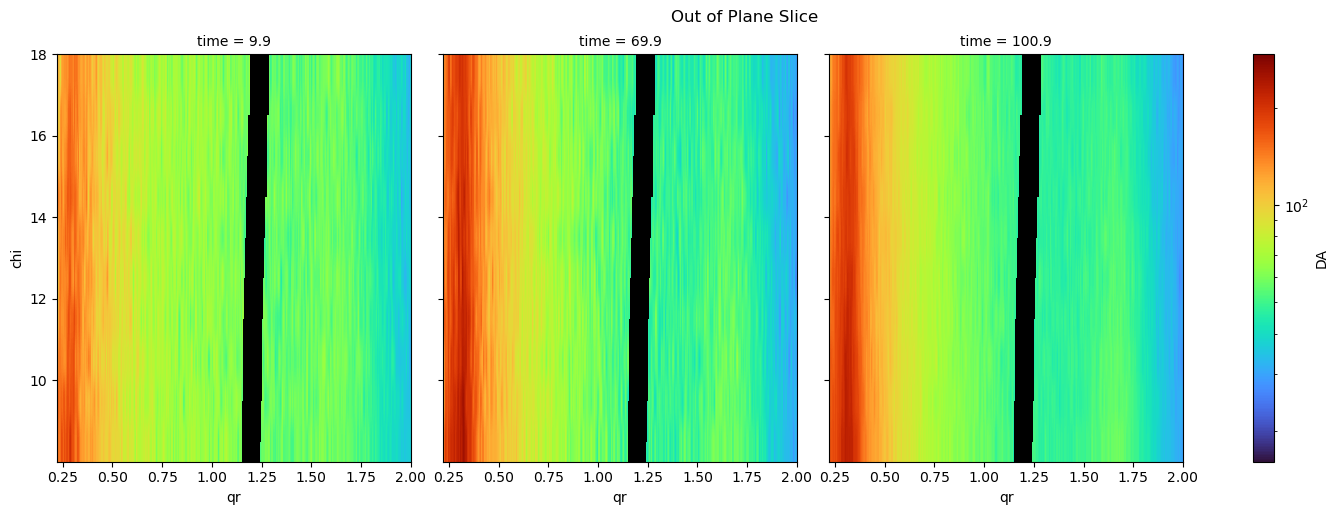

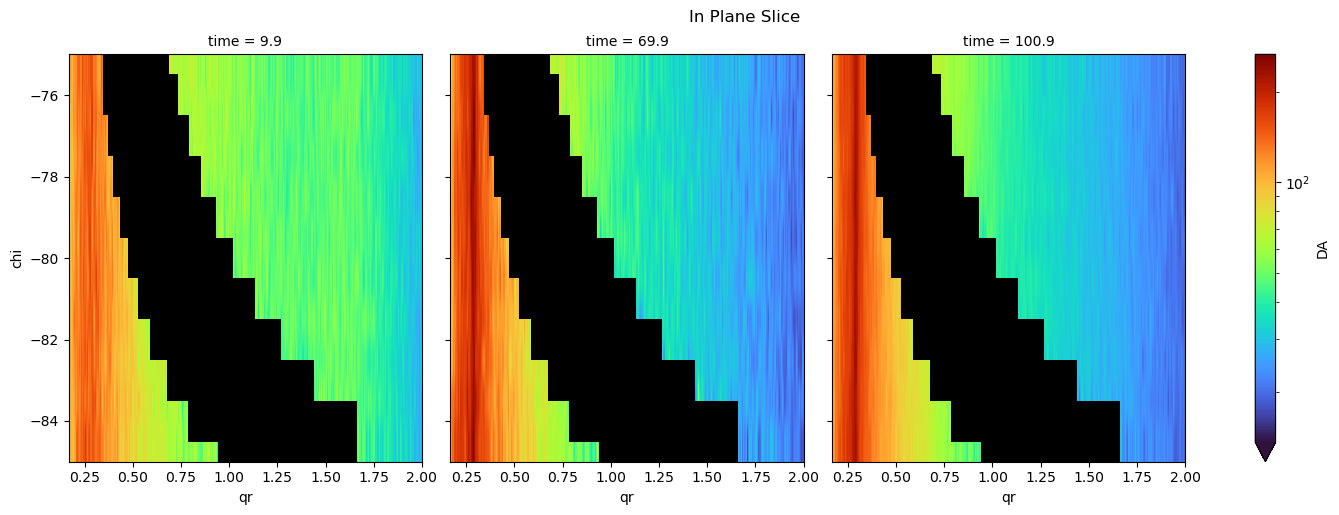

In [8]:
# Select chi regions, zoom into plot to check positions of detector gaps / anomalies
OOP_chi_min = 8
OOP_chi_max = 18

IP_chi_min = -85
IP_chi_max = -75

OOP_DA = DA.sel(chi=slice(OOP_chi_min, OOP_chi_max))
OOP_cmin = float(OOP_DA.compute().quantile(1e-2))
OOP_cmax = float(OOP_DA.compute().quantile(1-1e-5))

IP_DA = DA.sel(chi=slice(IP_chi_min, IP_chi_max))
IP_cmin = float(IP_DA.compute().quantile(1e-2))
IP_cmax = float(IP_DA.compute().quantile(1-1e-5))

axs = OOP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0.22,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(OOP_cmin, OOP_cmax), interpolation='antialiased')
axs.fig.suptitle('Out of Plane Slice', y=1.02)

axs = IP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(IP_cmin, IP_cmax), interpolation='antialiased')
axs.fig.suptitle('In Plane Slice', y=1.02)

plt.show()

In [9]:
# Interpolate detector gaps along a chosen dimension 
plt.close('all')
method='linear'
dim='chi'
interp_DA = DA.compute().interpolate_na(dim=dim, method=method)

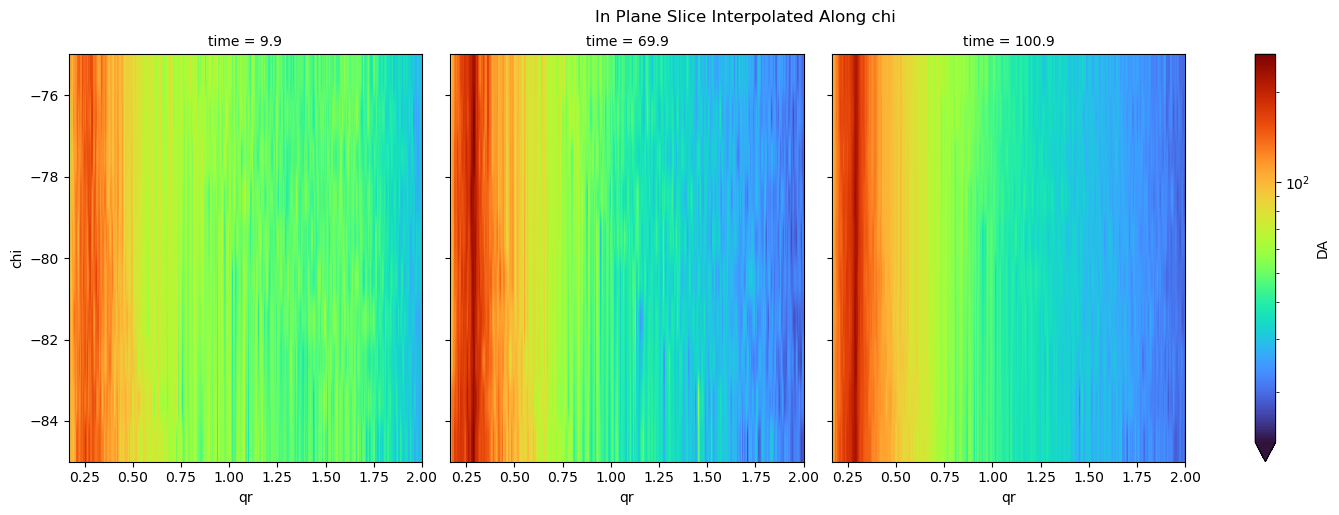

In [10]:
# Plot interpolated region, only necessary when detector gap is not easily to be avoided
# As seen above, that is only the case for my in my in plane region:
interp_IP_DA = interp_DA.sel(chi=slice(IP_chi_min, IP_chi_max))

axs = interp_IP_DA.sel(time=[10, 70, 100], method='nearest').sel(qr=slice(0,2)).plot.imshow(figsize=(15,5),
        col='time', cmap=cmap, norm=LogNorm(IP_cmin, IP_cmax), interpolation='antialiased')
axs.fig.suptitle(f'In Plane Slice Interpolated Along {dim}', y=1.02)

plt.show()
plt.close('all')

In [216]:
# Choose and save OOP & IP dataarrays as .csv's for Yilei
OOP_DA.sum('chi').to_pandas().to_csv(outPath.joinpath('tr_OOP-IP', f'{DA.material}-{DA.solvent}_{DA.sample_number}_OOP.csv'))
interp_IP_DA.sum('chi').to_pandas().to_csv(outPath.joinpath('tr_OOP-IP', f'{DA.material}-{DA.solvent}_{DA.sample_number}_IP.csv'))

#### Time resolved in plane & out of plane linecuts plotting

  0%|          | 0/73 [00:00<?, ?it/s]

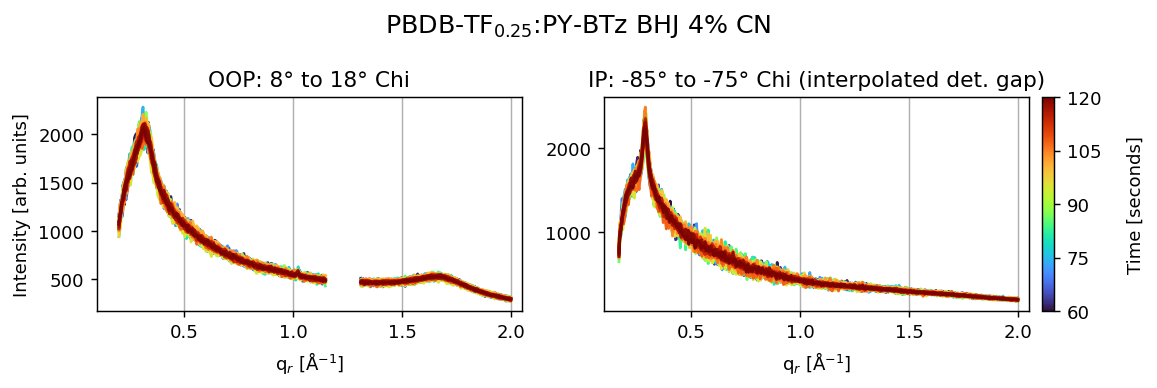

In [11]:
# Plot
time_slice = slice(60,120)

colors = cmap(np.linspace(0,1,len(DA.sel(time=time_slice).time)))
fig, axs = plt.subplots(1, 2, figsize=(9,3))

for i, time in enumerate(tqdm(DA.sel(time=time_slice).time)):
    # DA.sel(time=time, method='nearest').sel(chi=slice(7, 20), qr=slice(0.2,1.8)).sum('chi').plot.line(ax=axs[0], color=colors[i])
    OOP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(0.2,1.15)).plot.line(ax=axs[0], color=colors[i])
    OOP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(1.31,2)).plot.line(ax=axs[0], color=colors[i])
    interp_IP_DA.sum('chi').sel(time=time, method='nearest').sel(qr=slice(0,2)).plot.line(ax=axs[1], color=colors[i])
    
# Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=time_slice.start, vmax=time_slice.stop))
cax = axs[1].inset_axes([1.03, 0, 0.03, 1])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label=f'Time [seconds]', labelpad=14)
cbar.set_ticks(np.linspace(time_slice.start, time_slice.stop, 5).astype('int'))

# More plot customization
fig.suptitle('PBDB-TF$_{0.25}$:PY-BTz BHJ ' + f'{percent_dict[DA.solvent]}% CN', fontsize=14)
axs[0].set(xlim=(0.1, 2.05), title=f'OOP: {OOP_chi_min}° to {OOP_chi_max}° Chi', ylabel= 'Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
axs[0].grid(visible=True, which='major', axis='x')
axs[1].set(xlim=(0.1, 2.05), title=f'IP: {IP_chi_min}° to {IP_chi_max}° Chi (interpolated det. gap)', ylabel='', xlabel='q$_r$ [Å$^{-1}$]')
axs[1].grid(visible=True, which='major', axis='x')

fig.set(tight_layout=True, dpi=130)

# fig.savefig(outPath.joinpath('trGIWAXS_OOP-IP', f'{DA.material}_{DA.solvent}_{DA.sample_number}_{time_slice.start}to{time_slice.stop}s_linecuts.png'), dpi=150)

plt.show()
plt.close('all')

#### Time resolved in plane & out of plane 2D plotting

In [227]:
outPath

PosixPath('/nsls2/data/cms/proposals/2023-2/pass-311415/AL_processed_data')

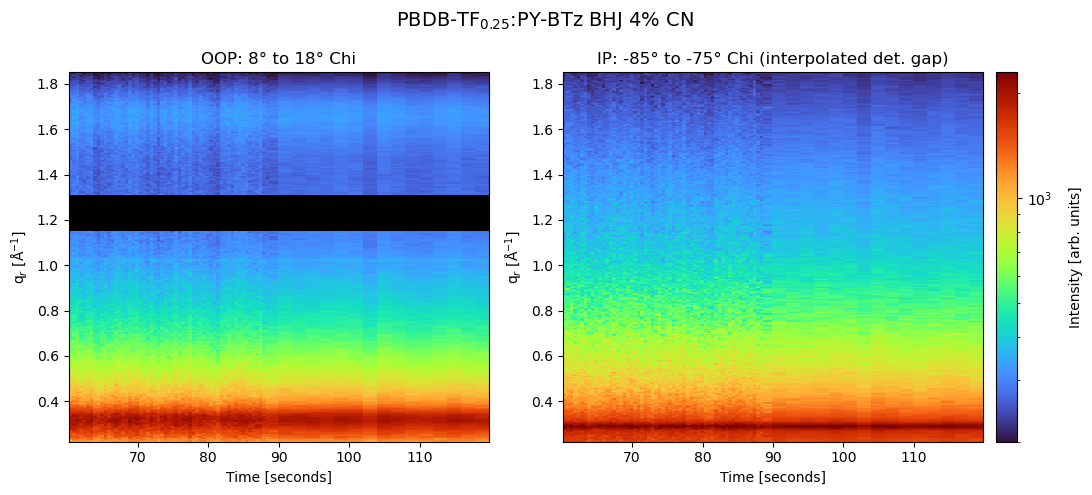

In [13]:
# Slice/sum data as needed for IP & OOP DataArrays
tr_OOP_DA = OOP_DA.sel(qr=slice(0.22,1.85), time=time_slice).sum('chi')
tr_OOP_DA = tr_OOP_DA.where((tr_OOP_DA.qr<1.15) | (tr_OOP_DA.qr>1.31))
tr_IP_DA = interp_IP_DA.sel(qr=slice(0.22,1.85), time=time_slice).sum('chi')

fig, axs = plt.subplots(1, 2, figsize=(11,5))

tr_OOP_DA.plot(ax=axs[0], x='time', cmap=cmap, norm=LogNorm(3.7e2, 2.3e3), add_colorbar=False)
tr_IP_DA.plot(ax=axs[1], x='time', cmap=cmap, norm=LogNorm(2e2, 2.3e3), add_colorbar=False)

# Create a ScalarMappable object with the colormap and normalization & add the colorbar to the figure
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(2e2, 2.3e3))
cax = axs[1].inset_axes([1.03, 0, 0.05, 1])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label='Intensity [arb. units]', labelpad=12)

fig.suptitle('PBDB-TF$_{0.25}$:PY-BTz BHJ ' + f'{percent_dict[DA.solvent]}% CN', fontsize=14)
fig.set(tight_layout=True)

axs[0].set(title=f'OOP: {OOP_chi_min}° to {OOP_chi_max}° Chi', ylabel='q$_r$ [Å$^{-1}$]', xlabel='Time [seconds]')
axs[1].set(title=f'IP: {IP_chi_min}° to {IP_chi_max}° Chi (interpolated det. gap)', ylabel='q$_r$ [Å$^{-1}$]', xlabel='Time [seconds]')

# fig.savefig(outPath.joinpath('trGIWAXS_OOP-IP', f'{DA.material}_{DA.solvent}_{DA.sample_number}_{time_slice.start}to{time_slice.stop}s_2D-plot.png'), dpi=150)

plt.show()
plt.close('all')

### Select 2D Plot

In [ ]:
cmap = plt.cm.turbo
cmap.set_bad('black')

In [ ]:
ax = recip_DA.sel(time=120, method='nearest').sel(q_z=slice(-0.01,2), q_para=slice(-2,2)).plot.imshow(cmap=cmap, norm=LogNorm(0.8, 4e1), figsize=(10,4), interpolation='antialiased')
ax.axes.set(aspect='equal', xlabel='$q_{para}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$')
plt.show()

In [ ]:
ax = DS.DA.sel(time=100, qr=slice(0,2), chi=slice(-90, 60)).plot.imshow(cmap=cmap, norm=LogNorm(4e1, 1e3), figsize=(8,6), interpolation='antialiased')
ax.axes.set(aspect=1.5e-2)
plt.show()

In [ ]:
caked_pybtz_CB_0to10s_series.sel(time=slice(0,1)).plot(col='time', col_size=4)

In [ ]:
caked_pybtz_CB_90to180s_series.sel(time=100, qr=slice(0,2), chi=slice(5,25)).sum('chi').plot()

In [ ]:
selected_dataarrays = [da for da in caked_DS.data_vars.values() 
                       if da.attrs['exposure_time'] == '5.00s' and 
                       da.attrs['incident_angle'] == 'th0.120']
len(selected_dataarrays)

## Single image GIWAXS Plotting

### 2D plots

#### Caked Images

#### Reciprocal Space Images

### 1D Plots

In [ ]:
# ax = recip_DA.sel(q_perp=slice(-2, 1), q_z=slice(-0.01, 2)).plot.imshow(norm=LogNorm(4e1, 2.5e3), cmap=plt.cm.turbo, interpolation='antialiased')
# ax.axes.set(aspect='equal', xlabel='$q_{perp}$ $[Å^{-1}]$', ylabel='$q_{z}$ $[Å^{-1}]$', title=f'1% CN, 5 s exposure, 0.12° incident angle')
# ax.figure.set(size_inches=(7,3.5), tight_layout=True)
# plt.show()
# # ax.figure.savefig(savePath.joinpath(f'{recip_da.material}_{recip_da.solvent}_qperp_{recip_da.incident_angle}_{recip_da.exposure_time}_{recip_da.scan_id}.png'), dpi=120)
# plt.close('all')

## Load filmetrics data

In [ ]:
sample = 'pybtz_cb_013'
filmdata = sorted(wliPath.joinpath(sample).glob('*.csv'))[:-1]

In [ ]:
filmdata

In [ ]:
thicknesses = []
for f in filmdata:
    df = pd.read_csv(f)
    df.columns = ['Wavelength', 'Reflectance']
    
    peaks = argrelextrema(df['Reflectance'].values, np.greater)
    beat_wavelengths = np.diff(df['Wavelength'].values[peaks])
    thickness = np.mean(df['Wavelength'].values[peaks])**2 / (2 * 1.3 * beat_wavelengths.mean())
    
    thicknesses.append(thickness)

In [ ]:
plt.plot(np.arange(0, len(filmdata), 1)[0:], thicknesses[0:])
plt.show()

In [ ]:
for i in range(0, 12):
    df = pd.read_csv(filmdata[i])
    df.columns = ['Wavelength', 'Reflectance']
    plt.plot(df['Wavelength'], df['Reflectance'])
    plt.show()

In [ ]:
peaks = argrelextrema(df['Reflectance'].values, np.greater)
# peaks

In [ ]:
beat_wavelengths = np.diff(df['Wavelength'].values[peaks])
# beat_wavelengths

In [ ]:
thickness = np.mean(df['Wavelength'].values[peaks])**2 / (2 * 1 * beat_wavelengths.mean())

In [ ]:
thickness

In [ ]:
len(beat_wavelengths)

In [ ]:
len(peaks)

In [ ]:
len(peaks[0])